# 0. Import libraries

In [1617]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
#sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 1. Import Data
Let's look at 5 random controls and 5 random PanIN samples. This is only to start to get an idea of what the spectrometry data looks like. 

First things first. The data files have very long names. I couldn't find out if thesse names were associated with some kind of information. I will start off by renaming all files in each folder to something more digestible. I may have to revisit this step if the file name do in fact, turn out to be important. Only one way to find out. 

In [1618]:
import os

# Switch to folder with 'control' files
os.chdir(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control')

# Check if I'm in the right directory
#print(os.getcwd())

# Create arrays to store new file names
control_samples = []
panIN_samples = []

# Rename files in the Control folder
for file in os.listdir():
    #print(file)     # Get file names
    #print(os.path.splitext(file))     # Separate file name from extension
    file_name, file_ext = os.path.splitext(file)     # Store the file name and extensions
    new_name = '{}{}'.format(file_name.split('_')[0], file_ext)     # Grab the first identifying number for each file
    #print(new_name)     # Confirm that the name tghwe have the name we want
    os.rename(file,new_name)     # Rename files
    control_samples.append(file)     # Append new file names to array
    
# Rename files in the PanIN folder
os.chdir(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN')
for file in os.listdir():
    file_name, file_ext = os.path.splitext(file)     # Store the file name and extensions
    new_name = '{}{}'.format(file_name.split('_')[0], file_ext)     # Grab the first identifying number for each file
    #print(new_name)     # Confirm that the name we have the name we want
    os.rename(file,new_name)     # Rename files
    panIN_samples.append(file)     # Append new file names to array
    
print(len(control_samples))
print(len(panIN_samples))

101
80


# 2. Exploratory Data Analysis

## 2.1 Create visualizations on a few samples

So we have 101 control samples and 80 PanIN samples. Not the biggest sample size but we work with what we have. 

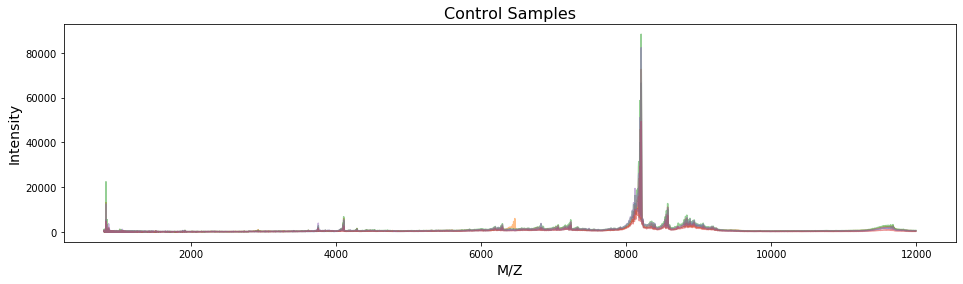

In [1619]:
# Plot 5 random control samples
plt.figure(figsize=(16,4))
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('Control Samples', fontsize=16)

# Read in 5 random Control samples
for i in range(0,5):
    n = np.random.randint(low=0, high=len(control_samples))
    cs = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control\{}'.format(control_samples[n]))
    plt.plot(cs['M/Z'], cs['Intensity'], alpha=0.5)

On a quick (and crude) visual inspection, the spectrometry files seem to show consistent peaks for the 5 random control samples. Let's try the same for the PanIN samples.

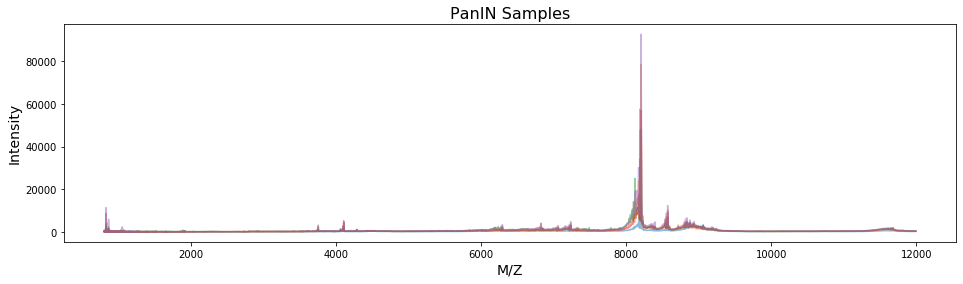

In [1620]:
# Plot 5 random PanIN samples
plt.figure(figsize=(16,4))
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('PanIN Samples', fontsize=16)

# Read in 5 random PanIN samples
for i in range(0,5):
    n = np.random.randint(low=0, high=len(panIN_samples))
    ps = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN\{}'.format(panIN_samples[n]))
    plt.plot(ps['M/Z'], ps['Intensity'], alpha=0.5)

Some PanIN samples show random peaks, but overall the peaks still seem fairly consistent. Now let's compare the controls and PanIN samples.

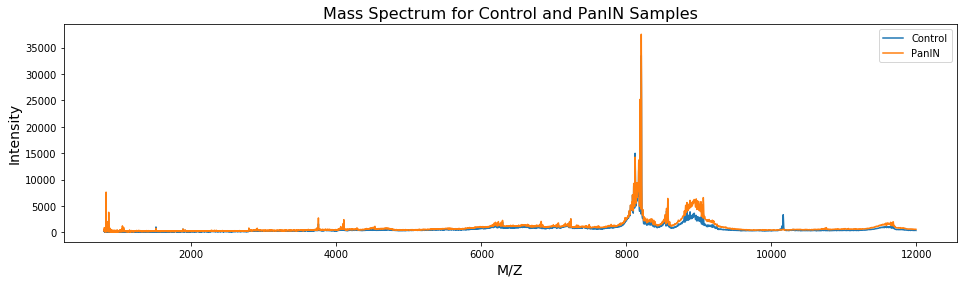

In [1621]:
n = np.random.randint(low=0, high=len(control_samples))
cs = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control\{}'.format(control_samples[n]))
m = np.random.randint(low=0, high=len(panIN_samples))
ps = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN\{}'.format(panIN_samples[m]))
                                                                                                                      
plt.figure(figsize=[16,4])
plt.plot(cs['M/Z'], cs['Intensity'], label='Control')
plt.plot(ps['M/Z'], ps['Intensity'], label='PanIN')
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('Mass Spectrum for Control and PanIN Samples', fontsize=16)
plt.legend()
plt.savefig(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Figures\Mass Spectrum.png')

If we were to just try to visually compare the spectra for a control and a PanIN sample, we could identify some peaks fairly well. But it would be quite difficult to identify all the key biomarkers. This is why we are trying to train a model to do this for us! 

In [1622]:
cs.head()

,M/Z,Intensity
0,800.00000,152.0
1,800.32000,273.0
2,800.64014,142.0
3,800.96040,167.0
4,801.28076,314.0


## 2.2 Noise Reduction and Scaling Data
The intensity values have a veery large range. Scaling the data may allow for better visualization. The idea here is to reduce noise and scale the data without losing any information. Using a standard scaler object did not seem to give good results, so I have attempted to manually scale the data. 

In [1623]:
# Baseline subtraction: Subtract the median of the bottom 20% of intensity values from all the values. 
# This should remove some of the noise. Might have to play around a little bit to make sure no information is lost. 
bottom_median = np.median(np.sort(cs['Intensity'])[:len(cs['Intensity'])//5])
cs['Intensity'] = cs['Intensity'].apply(lambda x: x-bottom_median if (x-bottom_median)>=0 else 0)
#cs = cs[cs['M/Z'] < 11000]

cs.head()

,M/Z,Intensity
0,800.00000,20.0
1,800.32000,141.0
2,800.64014,10.0
3,800.96040,35.0
4,801.28076,182.0


In [1624]:
# Rescaling: Divide all the values by the median of the top 5% intensity values
top_median = np.median(np.sort(cs['Intensity'])[::-1][:(len(cs['Intensity'])//20)])
cs['Intensity'] = cs['Intensity'].apply(lambda x: x/top_median)

# Take the square root to 'compress' the intensity values a little. 
# The actual intensity values are not important. We just need to be able to identify and visualize the peaks.  
cs['Intensity'] = np.sqrt(cs['Intensity'])
cs.head()


,M/Z,Intensity
0,800.00000,0.103238
1,800.32000,0.274117
2,800.64014,0.073000
3,800.96040,0.136571
4,801.28076,0.311431


In [1625]:
cs.describe()

,M/Z,Intensity
count,6771.000000,6771.000000
mean,4134.434794,0.309101
std,3059.113720,0.289243
min,800.000000,0.000000
25%,1574.160100,0.115424
50%,3097.470200,0.247557
75%,6094.888700,0.412307
max,11992.908000,4.216686


#### Create more visualizations with the scaled data

Let's now visualize this information as a colorbar, along with the spectrogram. The colorbar is simly a different way to visualize the spectrogram information. The more yellow the vertical line, the higher the intensity at that M/Z value. 

Note that most of the colorbar here will be blue, meaning the intensities for most of the M/Z values are near zero. The colorbar would be alot more useful if the intensity values were normalized from the device at the time of data collection. 


Note: This is  a colorbar for a single sample. Once all the samples are combined into a dataset, the rows will  refer to the corresponding sample number.

Text(0.5, 0, 'M/Z')

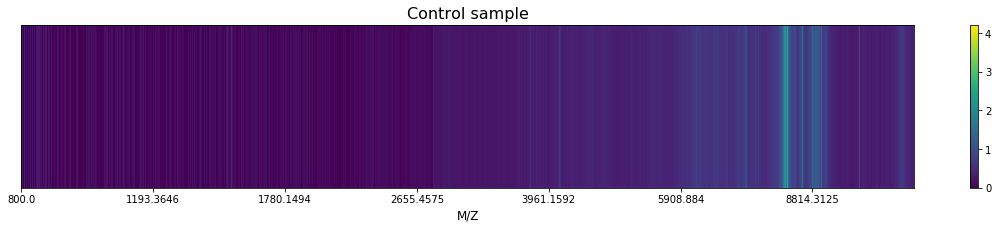

In [1626]:
# Plot the spectrogram as a colorbar
cs.set_index('M/Z')
plt.figure(figsize =(20,3))
plt.title('Control sample', fontsize = 16)
plt.imshow(cs['Intensity'][np.newaxis,:], aspect='auto', cmap='viridis')#, extent=[0,max(cs['M/Z']),2,0])
plt.yticks([])
plt.xticks(np.arange(0,7000,1000), cs['M/Z'][0:7000:1000])
plt.colorbar()
plt.xlabel('M/Z', fontsize = 12)

In order to identify the M/Z value for the associated peak, let's plot the spectrogram in an interactive plot. Note that intensity here actually refers to the scaled intensity. 

In [1627]:
px.line(cs, x=cs['M/Z'],y=cs['Intensity'], width = 1000, height = 300, title='Mass Spectrum')

## 2.3 Scaling and Visualization on all Samples

### 2.3.1 Combine all the samples into a single DataFrame
We want the rows to represent samples, and the columns to represent different M/Z values. 

The following steps are employed to achieve this:
* Step 1: Define a function that: 
    * Reads in a csv file from a specified path,
    * Applies the necessary scaling transformations,
    * Converts the rows to columns as required, and
    * Returns transformed DataFrame.
* Step 2: Define a function that combines all the transformed DataFrames (i.e. appends to a previously defined DataFrame 
* Step 3: Call the functions!

In [1628]:
cs = cs.set_index('M/Z')

In [1629]:
cs.transpose()

M/Z,800.00000,800.32000,800.64014,800.96040,801.28076,801.60126,801.92190,802.24260,802.56354,802.88460,...,11949.82000,11954.60100,11959.38300,11964.16700,11968.95300,11973.74000,11978.52900,11983.32000,11988.11300,11992.90800
Intensity,0.103238,0.274117,0.073,0.136571,0.311431,0.136571,0.0,0.251825,0.089407,0.136571,...,0.355386,0.372946,0.364272,0.33453,0.340843,0.365732,0.365732,0.356882,0.356882,0.346272


#### Define the transformation and scaling function:

In [1630]:
def transform_data(file_path):
    df = pd.read_csv(file_path)
    
    # Ensure there are no negative values
    #df['Intensity'] = df['Intensity'].apply(lambda x: x if x > 0 else 0)
    
    # Baseline substration. Substract the spectra with the median of bottom 20% intensity
    bottom_median = np.median(np.sort(df['Intensity'])[:len(df['Intensity'])//5])
    df['Intensity'] = df['Intensity'].apply(lambda x: x-bottom_median if (x-bottom_median)>=0 else 0)
    
    # Rescaling: Divide all the values by the highest intensity value
    # Update: This was throwing off results completely. Look into why this is the case.
    # Dividing by the median of the top values works better
    #df['Intensity'] = df['Intensity'] / np.max(df['Intensity'])

    # Rescale by dividing the intensity with the median of top 5% intensity
    top_median = np.median(np.sort(df['Intensity'])[::-1][:(len(df['Intensity'])//20)])
    df['Intensity'] = df['Intensity'].apply(lambda x: x/top_median)
            
    # Take the square root to 'compress' the intensity values a little. 
    # The actual intensity values are not important. We just need to be able to identify and visualize the peaks.  
    df['Intensity'] = np.sqrt(df['Intensity'])
    
    # Transpose the data as shown in the example above
    df = df.set_index('M/Z')
    df_transformed = df.transpose()

    
    return df_transformed

#### Define a function to read and combine all the samples:

In [1631]:
def combine_data(folder_path):
    df = pd.DataFrame()
    for file in os.listdir(folder_path):
        transformed = transform_data(file)
        df = pd.concat((df,transformed), ignore_index=True)
        
    return df    

#### These are the folders the files are stored in:

In [1632]:
# Control Samples are stored here
control_path = r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control'

# PanIN samples are stored here
panIN_path = r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN'

#### Call functions to make the combined dataset with all samples for each group

In [1633]:
os.chdir(control_path)
df_control = combine_data(os.getcwd())

os.chdir(panIN_path)
df_panIN = combine_data(os.getcwd())

#### Define a function to combine the control and panIN samples, and add a binary column titled 'has disease' to identify the sample

In [1634]:
def create_data_result(disease_group, control_group):
    disease_group['has disease'] = 1
    control_group['has disease'] = 0
    df = pd.concat((disease_group, control_group), ignore_index=True)
    return df

The data frame below now has both the control and disease datasets combined, along with an identifying column titled 'has disease'

In [1635]:
df_full= create_data_result(df_panIN, df_control)

### 2.3.2 Create spectrographs for both groups

#### Define a function to create a combined colorbar for all the samples in each group

In [1636]:
df_control.head()

M/Z,800.0,800.32,800.6401400000001,800.9604,801.28076,801.6012599999999,801.9219,802.2426,802.56354,802.8846,...,11954.601,11959.383,11964.167,11968.953000000001,11973.74,11978.528999999999,11983.32,11988.113000000001,11992.908000000001,has disease
0,0.192889,0.245721,0.000000,0.348439,0.352166,0.000000,0.261797,0.260548,0.102195,0.308178,...,0.390404,0.371996,0.378519,0.367139,0.359504,0.359504,0.341820,0.352629,0.365803,0
1,0.260186,0.270584,0.000000,0.394965,0.408699,0.000000,0.274633,0.312836,0.027126,0.292159,...,0.322677,0.338807,0.337719,0.312247,0.320962,0.332228,0.331118,0.313423,0.312836,0
2,0.165119,0.255259,0.048068,0.222363,0.768187,0.240340,0.174640,0.464050,0.276130,0.337847,...,0.326721,0.323166,0.323880,0.323880,0.326013,0.333025,0.305525,0.307034,0.275292,0
3,0.212211,0.281291,0.000000,0.290129,0.637955,0.203091,0.220002,0.431308,0.227525,0.331434,...,0.379948,0.361208,0.358870,0.344510,0.353553,0.351763,0.348155,0.337100,0.357696,0
4,0.209160,0.253305,0.000000,0.338339,0.352068,0.071442,0.210895,0.258293,0.109684,0.363781,...,0.338339,0.324029,0.347901,0.341022,0.322337,0.320067,0.320067,0.320636,0.316055,0


In [1637]:
def combined_colorbar(dataset):
    plt.figure(figsize=(20,3))
    plt.imshow(dataset, aspect='auto', cmap='viridis')
    plt.xticks(np.arange(0, 7000, 1000), dataset.columns[0:7000:1000])
    plt.colorbar()

Text(0, 0.5, 'Samples')

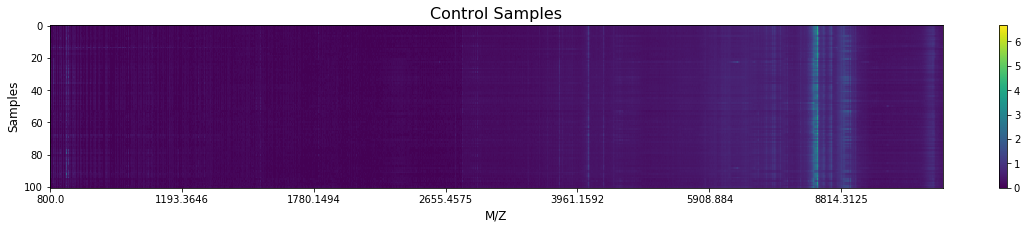

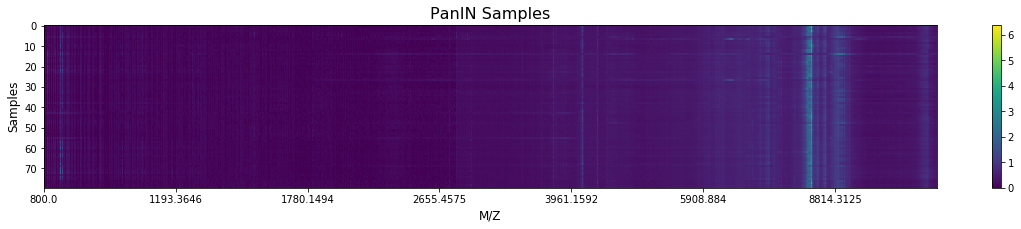

In [1638]:
combined_colorbar(df_control)
plt.title('Control Samples', fontsize = 16)
plt.xlabel('M/Z', fontsize = 12)
plt.ylabel('Samples', fontsize = 12)

combined_colorbar(df_panIN)
plt.title('PanIN Samples', fontsize = 16)
plt.xlabel('M/Z', fontsize = 12)
plt.ylabel('Samples', fontsize = 12)


### 2.3.3 Principal Component  Analysis and visualization

The spectrographs give a good intuitive understanding of the intensity values for different M/Z values. But it is still difficult to visually inspect the two and gather any differences between the two groups. This is perfect use case for Principal Component Analysis: a small but highly-dimensional dataset. We can plot the first two principal components.

In [1639]:
from sklearn.decomposition import PCA

X = df_full.drop('has disease', axis=1)
y = df_full['has disease']

pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)
#X.shape
#X_pca.shape

Text(0, 0.5, 'PC2')

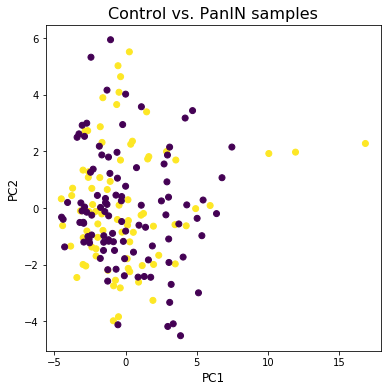

In [1640]:
# Scatter plot of first two principal components
plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_full['has disease'])
plt.title('Control vs. PanIN samples', fontsize=16)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)

Unfortunately, it doesn't look like 2 principal components can explain enough variance to distinguish between the two samples.
One question to answer is, how many components can explain a sufficient amount of variance?

Text(0, 0.5, 'Explained Variance')

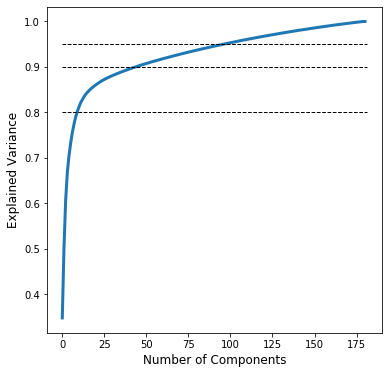

In [1658]:
plt.figure(figsize=[6,6])
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth = 3)
plt.plot([0, X_pca.shape[0]], [0.8, 0.8], color='k', linestyle='dashed', linewidth = 1)
plt.plot([0, X_pca.shape[0]], [0.9, 0.9], color='k', linestyle='dashed', linewidth = 1)
plt.plot([0, X_pca.shape[0]], [0.95, 0.95], color='k', linestyle='dashed', linewidth = 1)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Explained Variance', fontsize=12)

- It takes around 10 components to explain 80% of the variance, but about 100 to explain 95% of the variance. 
- 2 components only explain about 50% of the variance. This makes visualization difficult as evidenced by the PC2 vs PC1 plot. 

#  3. Machine Learning


Before we get to start classifying samples, we need to create a baseline model, tune hyperparameters, and do some feature selection. 

I will follow the steps outlined below:
- Train baseline random forest classifier and tune hyperparameters
- Identify the most important features that describe the variance upto a certain threshold (say 95%)
- Create a new dataset with just the identified important features
- Train a second classifer on this new dataset
- Potentially compare with different machine learning algorithms and pick the best result

## 3.1 Train Baseline Model

In [1707]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rf_base = RandomForestClassifier()
rf_base.fit(X_train,y_train)

pred_rf_baseline = rf_base.predict(X_test)

print(classification_report(y_test, pred_rf_baseline))
print(confusion_matrix(y_test, pred_rf_baseline))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78        33
           1       0.69      0.50      0.58        22

    accuracy                           0.71        55
   macro avg       0.70      0.67      0.68        55
weighted avg       0.71      0.71      0.70        55

[[28  5]
 [11 11]]


## 3.2 Hyperparameter tuning

### 3.2.1 Max depth

Max depth of 3 is maximizing the AUC score for the test set

1 depth
AUC train:  0.7214285714285714
AUC test:  0.4939516129032258
 
2 depth
AUC train:  0.8214285714285715
AUC test:  0.4939516129032258
 
3 depth
AUC train:  0.9303571428571429
AUC test:  0.5934139784946236
 
4 depth
AUC train:  0.9910714285714286
AUC test:  0.551747311827957
 
5 depth
AUC train:  0.9839285714285715
AUC test:  0.551747311827957
 
6 depth
AUC train:  0.9839285714285715
AUC test:  0.4408602150537634
 
7 depth
AUC train:  0.9821428571428572
AUC test:  0.4939516129032258
 
8 depth
AUC train:  0.9732142857142857
AUC test:  0.5376344086021505
 
9 depth
AUC train:  0.9732142857142857
AUC test:  0.5376344086021505
 
10 depth
AUC train:  0.9732142857142857
AUC test:  0.5376344086021505
 
15 depth
AUC train:  0.9732142857142857
AUC test:  0.5376344086021505
 
20 depth
AUC train:  0.9732142857142857
AUC test:  0.5376344086021505
 
30 depth
AUC train:  0.9732142857142857
AUC test:  0.5376344086021505
 
50 depth
AUC train:  0.9732142857142857
AUC test:  0.5376344086021505
 
70 

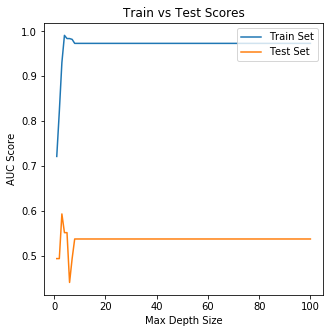

In [1679]:
results_train = []
results_test = []
max_depth_size = [1,2,3,4,5,6,7,8,9,10,15,20,30,50,70,100]

for depth in max_depth_size:
    model = RandomForestClassifier(max_depth=depth, n_jobs=-1, random_state=101)
    model.fit(X_train,y_train)
    print(depth, 'depth')
    pred1 = model.predict(X_train)
    pred_test = model.predict(X_test)
    roc1 = roc_auc_score(y_train, pred1)
    roc2 = roc_auc_score(y_test, pred_test)
    print('AUC train: ', roc1)
    print('AUC test: ', roc2)
    print(' ')
    results_train.append(roc1)
    results_test.append(roc2)

plt.figure(figsize=(5,5))
plt.plot(max_depth_size, results_train, label='Train Set')
plt.plot(max_depth_size, results_test, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('AUC Score')
plt.title('Train vs Test Scores')
plt.legend(loc="upper right")

### 3.2.2 n-estimators

Generally more is better, but there is a point of diminishing returns.
n = 1000 seems like an appropriate value keeping computation time in mind

1 trees
OOB Score:  0.5634920634920635
 
2 trees
OOB Score:  0.5873015873015873
 
3 trees
OOB Score:  0.5714285714285714
 
4 trees
OOB Score:  0.5714285714285714
 
5 trees
OOB Score:  0.5793650793650794
 
6 trees
OOB Score:  0.5555555555555556
 
7 trees
OOB Score:  0.5476190476190477
 
8 trees
OOB Score:  0.5634920634920635
 
9 trees
OOB Score:  0.5634920634920635
 
10 trees
OOB Score:  0.5317460317460317
 
15 trees
OOB Score:  0.5793650793650794
 
20 trees
OOB Score:  0.5714285714285714
 
50 trees
OOB Score:  0.6190476190476191
 
70 trees
OOB Score:  0.5793650793650794
 
100 trees
OOB Score:  0.626984126984127
 
200 trees
OOB Score:  0.6349206349206349
 
300 trees
OOB Score:  0.6111111111111112
 
500 trees
OOB Score:  0.6190476190476191
 
1000 trees
OOB Score:  0.6428571428571429
 
2000 trees
OOB Score:  0.6507936507936508
 
3000 trees
OOB Score:  0.6587301587301587
 
5000 trees
OOB Score:  0.6428571428571429
 


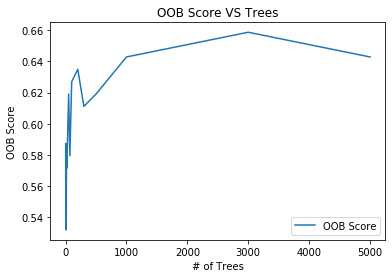

In [1683]:
results = []
n_estimator_values = [1,2,3,4,5,6,7,8,9,10,15,20,50,70,100,200,300,500,1000,2000,3000,5000]

for num_trees in n_estimator_values:
    model = RandomForestClassifier(n_estimators=num_trees, oob_score=True, n_jobs=-1, random_state=101)
    model.fit(X_train, y_train)
    print(num_trees, 'trees')
    oob = model.oob_score_
    print('OOB Score: ', oob)
    results.append(oob)
    print(' ')
    
plt.plot(n_estimator_values, results, label='OOB Score')
plt.xlabel('# of Trees')
plt.ylabel('OOB Score')
plt.title('OOB Score VS Trees')
plt.legend(loc="lower right")
plt.show()

### 3.2.3 Min Samples in Leaves

7 leaves is a good value to choose based on the plot

1 min_samples
OOB Score:  0.5317460317460317
 
2 min_samples
OOB Score:  0.5476190476190477
 
3 min_samples
OOB Score:  0.5476190476190477
 
4 min_samples
OOB Score:  0.5873015873015873
 
5 min_samples
OOB Score:  0.5555555555555556
 
6 min_samples
OOB Score:  0.5873015873015873
 
7 min_samples
OOB Score:  0.6031746031746031
 
8 min_samples
OOB Score:  0.6031746031746031
 
9 min_samples
OOB Score:  0.5873015873015873
 
10 min_samples
OOB Score:  0.5714285714285714
 
20 min_samples
OOB Score:  0.6031746031746031
 
50 min_samples
OOB Score:  0.5555555555555556
 


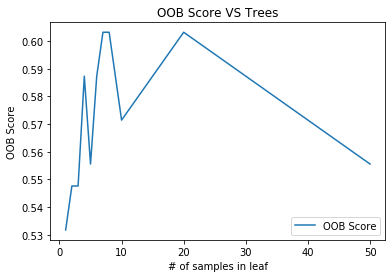

In [1687]:
results = []
min_samples_leaf_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50]

for min_samples in min_samples_leaf_values:
    model = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=101, min_samples_leaf=min_samples)
    model.fit(X_train, y_train)
    oob = model.oob_score_
    print(min_samples, 'min_samples')
    print('OOB Score: ', oob)
    print(' ')
    results.append(oob)
    
plt.plot(min_samples_leaf_values, results, label='OOB Score')
plt.xlabel('# of samples in leaf')
plt.ylabel('OOB Score')
plt.title('OOB Score VS Trees')
plt.legend(loc="lower right")

### 3.2.4 Retrain Model with New Hyperparameters

In [1708]:
rf_tuned = RandomForestClassifier(max_depth=3, n_estimators=1000, min_samples_leaf=7)
rf_tuned.fit(X_train,y_train)

pred_rf_tuned = rf_tuned.predict(X_test)

print(classification_report(y_test, pred_rf_tuned))
print(confusion_matrix(y_test, pred_rf_tuned))

              precision    recall  f1-score   support

           0       0.69      0.88      0.77        33
           1       0.69      0.41      0.51        22

    accuracy                           0.69        55
   macro avg       0.69      0.64      0.64        55
weighted avg       0.69      0.69      0.67        55

[[29  4]
 [13  9]]


## 3.3 Identify Important  Features

Now that the hyperparameters are optimized, I will use random forest to identify important features. I will also be using the entire dataset instead of splitting it.  

Text(0, 0.5, 'Explained Variance')

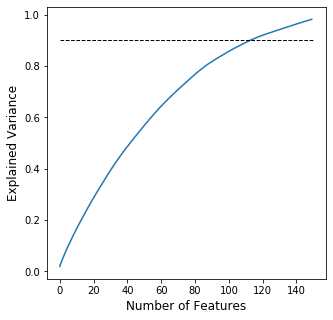

In [1660]:
important_features = rf.feature_importances_

plt.figure(figsize=(5,5))
plt.plot(np.cumsum(np.sort(important_features)[::-1][:150]))
plt.plot([0, 150], [0.9, 0.9], color='k', linestyle='dashed', linewidth = 1)
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Explained Variance', fontsize=12)